# TODO

solid angle correction - FM

train difference calculation function


# 1. PLOTTING SCRIPTS

In [1]:
def plot_pulses(q, Sazi_in, skip=1, vminmax=None):
    
    colors = pl.cm.jet(np.linspace(0,1,Sazi_in.shape[0]))

    fig, ax = plt.subplots(1,1)
    for i in range(0, Sazi_in.shape[0], skip):
        ax.plot(q, Sazi_in[i, :], color = colors[i])

    
def plot_mean_pulses(q, Sazi_in):

    fig, ax = plt.subplots(1,1)
    ax.plot(q, np.nanmean(Sazi_in,0))
    
def plot_2d_pulses(q, cellIDs_in, dS, vminmax):
    cells = np.unique(cellIDs)
    fig, ax = plt.subplots(1,1)
    ax.pcolor(q, cells[:175], dS[:175,:], cmap='bwr',vmin=vminmax[0], vmax=vminmax[1])



# 2. IMPORTS

In [2]:
import os
import sys
import h5py as h5
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import pylab as pl


# 3. LOAD RUN

In [3]:
def load_data_filipe(file_inp, file_laser,norm=True, qnorm=[12,14]):
    
    #read in scattering data
    with h5.File(file_inp, 'r') as f:
        print(f['entry_1'].keys())
        Sazi = np.asarray(f['entry_1']['radialavg'])
        Sazi_var = np.asarray(f['entry_1']['radialvar'])
        q = np.asarray(f['entry_1']['q'])
        cellID = np.asarray(f['entry_1']['cellId'][:,0]).squeeze()
        pulseID = np.asarray(f['entry_1']['pulseId'])
        trainID = np.asarray(f['entry_1']['trainId'])

    # read in laser data
    with h5.File(file_laser, 'r') as f:
        laser_on = np.asarray(f['entry_1']['laser_on'])
        laser_train_id = np.asarray(f['entry_1']['trainId'])
    


    t=0
    for i in range(len(cellID)-1):
        if cellID[i]<cellID[i+1]:
            train = trainID[t]
        elif cellID[i]>cellID[i+1]:
            t = t+1
            train=trainID[t]
    
    #copy train ids for every pulse
    pump = trainID[:]
    
    #for each train id
    for i, tid in enumerate(laser_train_id):
        #where the train id of the pulse is equal to the current train id, 
        #set it to whatever the laser state is
        pump[np.where(pump==tid)] = laser_on[i]        
    
    cellIDs = cellID[:Sazi.shape[0]]
    pulseIDs = pulseID[:Sazi.shape[0]]
    pumps = pump[:Sazi.shape[0]]
    pulseIDs = pulseID[:Sazi.shape[0]]
    trainIDs = trainID[:Sazi.shape[0]]
    
    if norm:
        
        sum_norm = np.nansum(np.abs(Sazi[:,np.logical_and(q>qnorm[0], q<qnorm[1])]),1)
        
        for i in range(Sazi.shape[0]):
            Sazi[i,:] = Sazi[i,:]/sum_norm[i]
        
    return Sazi, Sazi_var, q, cellIDs, pumps, pulseIDs, trainIDs

In [4]:

run = 'r0134'

file_filipe1 = f'/gpfs/exfel/exp/SPB/202202/p003046/scratch/data/{run}_proc_radavg.h5'
file_filipe2 = f'/gpfs/exfel/exp/SPB/202202/p003046/scratch/data/{run}_proc_laser.h5'


Sazi_raw, Sazi_var_raw, q, cellID_raw, pump_raw, pulseIDs_raw, trainIDs_raw = load_data_filipe(file_filipe1,file_filipe2, qnorm=[12,14])



<KeysViewHDF5 ['cellId', 'detector_distance', 'good_pixels', 'polarization', 'pulseId', 'q', 'radialavg', 'radialcount', 'radialsum', 'radialvar', 'solid_angle', 'trainId', 'wavelength']>


# 4. DUD PULSE FILTER

Filter out curves where sum is 0 (due to nan values)

In [5]:
def filter_dud_pulses(Sazi_in, Sazi_var_in, cellID_in, pump_in, pulseIDs_in, trainIDs_in):
    
    # sum of the absolute scattering curves for each pulse
    sazi_sum_abs = np.nansum(Sazi_in,1)
    
    # locations where the sum is greater then 0
    # if sum is 0, it means means pulse only had nans
    sumgt0_loc = np.where(np.nansum(Sazi_in, axis=1)>0)
 
    # keep curves where sum > 0
    Sazi_out = Sazi_in[sumgt0_loc,:][0]
    Sazi_var_out = Sazi_var_in[sumgt0_loc,:][0]
    cellID_out = cellID_in[sumgt0_loc]
    pump_out = pump_in[sumgt0_loc]
    pulseIDs_out = pulseIDs_in[sumgt0_loc]
    trainIDs_out = trainIDs_in[sumgt0_loc]

    # print filter info
    print(f'Starting with {Sazi_in.shape[0]} frames.')
    print(f'Filtering {Sazi_in.shape[0] -Sazi_out.shape[0]} frames.')
    print(f'{Sazi_out.shape[0]} frames remain.')

    return Sazi_out, Sazi_var_out, cellID_out, pump_out, pulseIDs_out, trainIDs_out

In [6]:
Sazi_df, Sazi_var_df, cellID_df, pump_df , pulseIDs_df, trainIDs_df = filter_dud_pulses(Sazi_raw, Sazi_var_raw, cellID_raw, pump_raw, pulseIDs_raw, trainIDs_raw)

Starting with 631654 frames.
Filtering 24138 frames.
607516 frames remain.


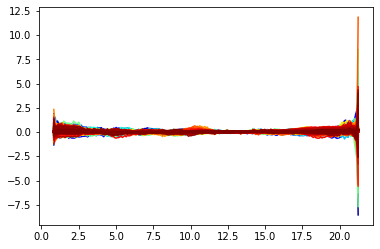

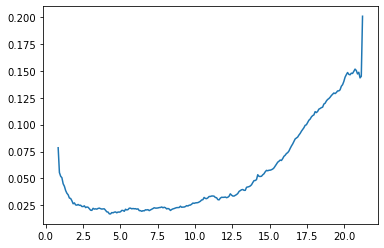

In [7]:
plot_pulses(q, Sazi_df, skip=100)
plot_mean_pulses(q, Sazi_df)

# 5.1 FILTER ABSOLUTE

In [8]:
def mad(arr, axis=None, keepdims=True):
    median = np.median(arr, axis=axis, keepdims=True)
    mad = np.median(np.abs(arr-median),axis=axis, keepdims=keepdims)
    return mad

Filter region outside of mean bounds, which are passed as arguments in the function filter_abs()

In [9]:
def filter_abs(Sazi_in, q, q_range, cellID_in, pump_in, pulseIDs_in, trainIDs_in, sigma, mean_bounds):
    
    # mean of the absolute scattering curves for each pulse
    ##sazi_mean_abs = np.nanmean(Sazi_in,1)
    sazi_mean_abs = np.nanmean(Sazi_in[:,np.logical_and(q>q_range[0], q<q_range[1])],1)

    # region where the sum is within the mean_bounds range
    mean_mask_loc = np.logical_and(sazi_mean_abs>mean_bounds[0], sazi_mean_abs<mean_bounds[1])

    # mean value of all the runs within the mean_bounds range
    sazi_mean_mean = np.nanmean(sazi_mean_abs[mean_mask_loc])
    
    # std value of all the runs within the mean_bounds range
    sazi_mean_std = mad(sazi_mean_abs[mean_mask_loc])
    
    #all_mean = np.nanmeam(Sazi_in[:,np.logical_and(q>q_range[0], q<q_range[1])])
    
    #frame_stds = np.nanstd(Sazi_in[:,np.logical_and(q>q_range[0], q<q_range[1])],1)

    #plot a histogram of the summed scattering curve values, with mean and std
    fig, axes = plt.subplots(1,1)
    plt.hist(sazi_mean_abs, bins=500)
    plt.title('Before filtering')
    #axes.axvline(sazi_mean_mean, color='red')
    #axes.axvline(sazi_mean_mean-sazi_mean_std, color='green')
    #axes.axvline(sazi_mean_mean+sazi_mean_std, color='green')
    #axes.set_xlim(mean_bounds)
    #axes.axvline(sazi_sum_mean-2*sazi_sum_std, color='purple')
    #axes.axvline(sazi_sum_mean+2*sazi_sum_std, color='purple')
    
    
    # pulses where the summed scattering curve values are within the mean +/- std*sigma
    sum_mean_mask_loc = np.logical_and(sazi_mean_abs>sazi_mean_mean-sazi_mean_std*sigma,
                              sazi_mean_abs<sazi_mean_mean+sazi_mean_std*sigma)
    
    # keep curves within this range
    cellID_out = cellID_in[sum_mean_mask_loc]
    pump_out = pump_in[sum_mean_mask_loc]
    Sazi_out = Sazi_in[sum_mean_mask_loc,:]
    pulseIDs_out = pulseIDs_in[sum_mean_mask_loc]
    trainIDs_out = trainIDs_in[sum_mean_mask_loc]
    

    # print filter info
    print(f'Starting with {Sazi_in.shape[0]} frames.')
    print(f'Filtering {Sazi_in.shape[0] -Sazi_out.shape[0]} frames.')
    print(f'{Sazi_out.shape[0]} frames remain.')
    
    #plot a histogram of the summed scattering curve values, with mean and std after filtering
    
    sazi_mean_abs2 = np.nanmean(Sazi_out[:,np.logical_and(q>q_range[0], q<q_range[1])],1)

    fig, axes = plt.subplots(1,1)
    plt.hist(sazi_mean_abs2, bins=500)
    plt.title('After filtering')
    axes.axvline(sazi_mean_mean, color='red')
    axes.axvline(sazi_mean_mean-sazi_mean_std, color='green')
    axes.axvline(sazi_mean_mean+sazi_mean_std, color='green')
    #axes.axvline(mean-2*std, color='purple')
    #axes.axvline(mean+2*std, color='purple')
    
    threshold = np.array(np.where(cellID_out < 176, 1, 0), dtype =bool)

    cellID_out = cellID_out[threshold]
    pump_out = pump_out[threshold]
    Sazi_out = Sazi_out[threshold,:]
    pulseIDs_out = pulseIDs_out[threshold]
    trainIDs_out = trainIDs_out[threshold]    

    return Sazi_out, cellID_out, pump_out, pulseIDs_out, trainIDs_out

Starting with 607516 frames.
Filtering 99017 frames.
508499 frames remain.


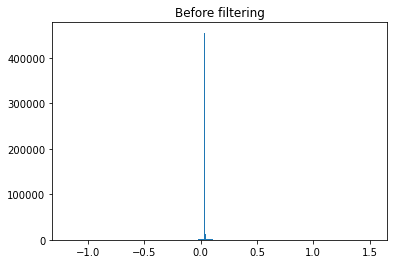

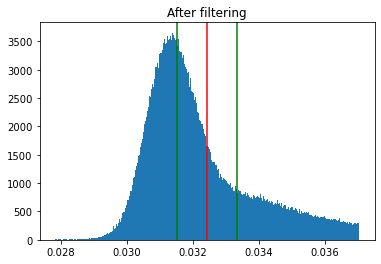

In [10]:
Sazi_mf, cellID_mf, pump_mf, pulseIDs_mf, trainIDs_mf = filter_abs(Sazi_df, q, [0.1, 2.5], cellID_df, pump_df, pulseIDs_df, trainIDs_df, sigma=5, mean_bounds=[0.01,0.04])

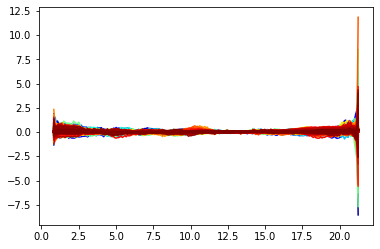

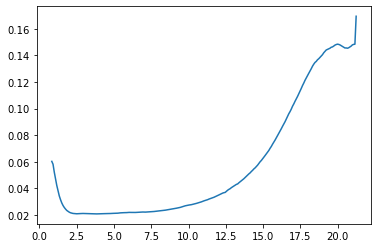

In [11]:
plot_pulses(q, Sazi_df, skip=100)
plot_mean_pulses(q, Sazi_mf)

# 5.2 FILTER PEAK

Filter region outside of mean bounds, passed as arguments in the function filter_peak() as for filter_abs(). 

Then filter around peak (when distribution is skewed, e.g. run 134, peak =/= mean).

In [12]:

def filter_peak(Sazi_in, q, q_range, cellID_in, pump_in, pulseIDs_in, trainIDs_in, sigma, mean_bounds, sigma_peak):
    
    # mean of the absolute scattering curves for each pulse
    ##sazi_mean_abs = np.nanmean(Sazi_in,1)
    sazi_mean_abs = np.nanmean(Sazi_in[:,np.logical_and(q>q_range[0], q<q_range[1])],1)

    # region where the sum is within the mean_bounds range
    mean_mask_loc = np.logical_and(sazi_mean_abs>mean_bounds[0], sazi_mean_abs<mean_bounds[1])

    # mean value of all the runs within the mean_bounds range
    sazi_mean_mean = np.nanmean(sazi_mean_abs[mean_mask_loc])
    
    # std value of all the runs within the mean_bounds range
    sazi_mean_std = mad(sazi_mean_abs[mean_mask_loc])

    #all_mean = np.nanmeam(Sazi_in[:,np.logical_and(q>q_range[0], q<q_range[1])])
    
    #frame_stds = np.nanstd(Sazi_in[:,np.logical_and(q>q_range[0], q<q_range[1])],1)

    #plot a histogram of the summed scattering curve values, with mean and std
    fig, axes = plt.subplots(1,1)
    plt.hist(sazi_mean_abs, bins=500)
    plt.title('Before filtering')
    axes.axvline(sazi_mean_mean, color='red')
    axes.axvline(sazi_mean_mean-sazi_mean_std, color='green')
    axes.axvline(sazi_mean_mean+sazi_mean_std, color='green')
    #axes.set_xlim(mean_bounds)
    #axes.axvline(sazi_sum_mean-2*sazi_sum_std, color='purple')
    #axes.axvline(sazi_sum_mean+2*sazi_sum_std, color='purple')
    
    
    # pulses where the summed scattering curve values are within the mean +/- std*sigma
    sum_mean_mask_loc = np.logical_and(sazi_mean_abs>sazi_mean_mean-sazi_mean_std*sigma,
                              sazi_mean_abs<sazi_mean_mean+sazi_mean_std*sigma)

    # keep curves within this range
    cellID_out = cellID_in[sum_mean_mask_loc]
    pump_out = pump_in[sum_mean_mask_loc]
    Sazi_out = Sazi_in[sum_mean_mask_loc,:]
    pulseIDs_out = pulseIDs_in[sum_mean_mask_loc]
    trainIDs_out = trainIDs_in[sum_mean_mask_loc]
    
    # print filter info
    print(f'# Avg filtering')
    print(f'Starting with {Sazi_in.shape[0]} frames.')
    print(f'Filtering {Sazi_in.shape[0] -Sazi_out.shape[0]} frames.')
    print(f'{Sazi_out.shape[0]} frames remain.')
    
    #plot a histogram of the summed scattering curve values, with mean and std after filtering
    
    sazi_mean_abs2 = np.nanmean(Sazi_out[:,np.logical_and(q>q_range[0], q<q_range[1])],1)
    #print(sazi_mean_abs2.shape)
    fig, axes = plt.subplots(1,1)
    y, x, _ = plt.hist(sazi_mean_abs2, bins=500)
    plt.title('After filtering')
    axes.axvline(sazi_mean_mean, color='green', linestyle = '-.')
    axes.axvline(sazi_mean_mean-sazi_mean_std, color='green', linestyle = '-.')
    axes.axvline(sazi_mean_mean+sazi_mean_std, color='green', linestyle = '-.')

    #axes.axvline(mean-2*std, color='purple')
    #axes.axvline(mean+2*std, color='purple')

    peak = x[np.where(y == y.max())]
    
    axes.axvline(peak, color='red')
    axes.axvline(peak-sazi_mean_std, color='red')
    axes.axvline(peak+sazi_mean_std, color='red')  
    
    sum_mean_mask_loc = np.logical_and(sazi_mean_abs>peak-sazi_mean_std*sigma_peak,
                              sazi_mean_abs<peak+sazi_mean_std*sigma_peak)    
    #peak_x = np.where(avg_mean == peak_x)
    
    # keep curves within this range
    cellID_out = cellID_in[sum_mean_mask_loc]
    pump_out = pump_in[sum_mean_mask_loc]
    Sazi_out = Sazi_in[sum_mean_mask_loc,:]
    pulseIDs_out = pulseIDs_in[sum_mean_mask_loc]
    trainIDs_out = trainIDs_in[sum_mean_mask_loc]
     # print filter info
    print(f'# Peak filtering')
    print(f'Starting with {Sazi_in.shape[0]} frames.')
    print(f'Filtering {Sazi_in.shape[0] -Sazi_out.shape[0]} frames.')
    print(f'{Sazi_out.shape[0]} frames remain.')   
    
    sazi_mean_abs3 = np.nanmean(Sazi_out[:,np.logical_and(q>q_range[0], q<q_range[1])],1)
 
    #fig, axes = plt.subplots(1,1)
    #plt.hist(sazi_mean_abs3, bins=500)
    #plt.title('After peak filtering (filter centered on peak)')

    fig, axes = plt.subplots(1,1)
    plt.hist(sazi_mean_abs3, bins=500)
    plt.title('After peak filtering (filter centered on peak)')
    axes.axvline(peak, color='red')
    axes.axvline(peak-sazi_mean_std, color='green')
    axes.axvline(peak+sazi_mean_std, color='green')  
    
    threshold = np.array(np.where(cellID_out < 176, 1, 0), dtype =bool)

    cellID_out = cellID_out[threshold]
    pump_out = pump_out[threshold]
    Sazi_out = Sazi_out[threshold,:]
    pulseIDs_out = pulseIDs_out[threshold]
    trainIDs_out = trainIDs_out[threshold]    
    
    return Sazi_out, cellID_out, pump_out, pulseIDs_out, trainIDs_out

# Avg filtering
Starting with 607516 frames.
Filtering 99017 frames.
508499 frames remain.
# Peak filtering
Starting with 607516 frames.
Filtering 174411 frames.
433105 frames remain.


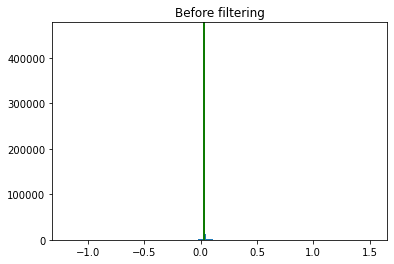

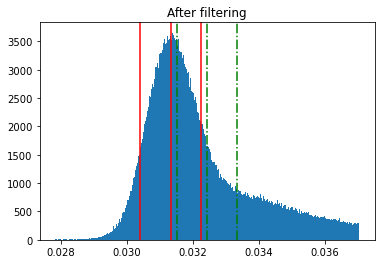

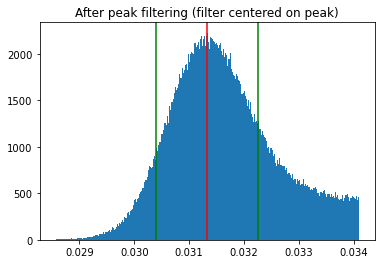

In [28]:
Sazi_pf, cellID_pf, pump_pf, pulseIDs_pf, trainIDs_pf = filter_peak(Sazi_df, q, [0.1, 2.5], cellID_df, pump_df, pulseIDs_df, trainIDs_df, sigma=5, mean_bounds=[0.01,0.04], sigma_peak = 3)

# 5.3 FILTER VARIANCE

Filter region outside of mean bounds, passed as arguments in the function filter_peak().

Then filter around peak (when distribution is skewed, e.g. run 134, peak =/= mean).

Finally use arguments peakvar and varbounds to filter variance

In [14]:
from scipy.signal import argrelextrema

In [15]:
def filter_var(Sazi_in, Sazi_var_in, q, q_range, cellID_in, pump_in, pulseIDs_in, trainIDs_in, sigma, mean_bounds, sigma_peak, peakvar, varbounds):
    # mean of the absolute scattering curves for each pulse
    ##sazi_mean_abs = np.nanmean(Sazi_in,1)
    sazi_mean_abs = np.nanmean(Sazi_in[:,np.logical_and(q>q_range[0], q<q_range[1])],1)

    # region where the sum is within the mean_bounds range
    mean_mask_loc = np.logical_and(sazi_mean_abs>mean_bounds[0], sazi_mean_abs<mean_bounds[1])

    # mean value of all the runs within the mean_bounds range
    sazi_mean_mean = np.nanmean(sazi_mean_abs[mean_mask_loc])
    
    # std value of all the runs within the mean_bounds range
    sazi_mean_std = mad(sazi_mean_abs[mean_mask_loc])

    #all_mean = np.nanmeam(Sazi_in[:,np.logical_and(q>q_range[0], q<q_range[1])])
    
    #frame_stds = np.nanstd(Sazi_in[:,np.logical_and(q>q_range[0], q<q_range[1])],1)

    #plot a histogram of the summed scattering curve values, with mean and std
    fig, axes = plt.subplots(1,1)
    plt.hist(sazi_mean_abs, bins=500)
    plt.title('Before filtering')
    axes.axvline(sazi_mean_mean, color='red')
    axes.axvline(sazi_mean_mean-sazi_mean_std, color='green')
    axes.axvline(sazi_mean_mean+sazi_mean_std, color='green')
    #axes.set_xlim(mean_bounds)
    #axes.axvline(sazi_sum_mean-2*sazi_sum_std, color='purple')
    #axes.axvline(sazi_sum_mean+2*sazi_sum_std, color='purple')
    
    
    # pulses where the summed scattering curve values are within the mean +/- std*sigma
    sum_mean_mask_loc = np.logical_and(sazi_mean_abs>sazi_mean_mean-sazi_mean_std*sigma,
                              sazi_mean_abs<sazi_mean_mean+sazi_mean_std*sigma)

    # keep curves within this range
    cellID_out = cellID_in[sum_mean_mask_loc]
    pump_out = pump_in[sum_mean_mask_loc]
    Sazi_out = Sazi_in[sum_mean_mask_loc,:]
    pulseIDs_out = pulseIDs_in[sum_mean_mask_loc]
    trainIDs_out = trainIDs_in[sum_mean_mask_loc]
    
    # print filter info
    print(f'# Avg filtering')
    print(f'Starting with {Sazi_in.shape[0]} frames.')
    print(f'Filtering {Sazi_in.shape[0] -Sazi_out.shape[0]} frames.')
    print(f'{Sazi_out.shape[0]} frames remain.')
    
    #plot a histogram of the summed scattering curve values, with mean and std after filtering
    
    sazi_mean_abs2 = np.nanmean(Sazi_out[:,np.logical_and(q>q_range[0], q<q_range[1])],1)
    #print(sazi_mean_abs2.shape)
    fig, axes = plt.subplots(1,1)
    y, x, _ = plt.hist(sazi_mean_abs2, bins=500)
    plt.title('After filtering')
    axes.axvline(sazi_mean_mean, color='green', linestyle = '-.')
    axes.axvline(sazi_mean_mean-sazi_mean_std, color='green', linestyle = '-.')
    axes.axvline(sazi_mean_mean+sazi_mean_std, color='green', linestyle = '-.')

    #axes.axvline(mean-2*std, color='purple')
    #axes.axvline(mean+2*std, color='purple')

    peak = x[np.where(y == y.max())]
    
    axes.axvline(peak, color='red')
    axes.axvline(peak-sazi_mean_std, color='red')
    axes.axvline(peak+sazi_mean_std, color='red')  
    
    sum_mean_mask_loc = np.logical_and(sazi_mean_abs>peak-sazi_mean_std*sigma_peak,
                              sazi_mean_abs<peak+sazi_mean_std*sigma_peak)    
    #peak_x = np.where(avg_mean == peak_x)
    
    # keep curves within this range
    cellID_out = cellID_in[sum_mean_mask_loc]
    pump_out = pump_in[sum_mean_mask_loc]
    Sazi_out = Sazi_in[sum_mean_mask_loc,:]
    Sazi_var_out = Sazi_var_in[sum_mean_mask_loc,:]
    pulseIDs_out = pulseIDs_in[sum_mean_mask_loc]
    trainIDs_out = trainIDs_in[sum_mean_mask_loc]
     # print filter info
    print(f'# Peak filtering')
    print(f'Starting with {Sazi_in.shape[0]} frames.')
    print(f'Filtering {Sazi_in.shape[0] -Sazi_out.shape[0]} frames.')
    print(f'{Sazi_out.shape[0]} frames remain.')   
    
    sazi_mean_abs3 = np.nanmean(Sazi_out[:,np.logical_and(q>q_range[0], q<q_range[1])],1)
 
    #fig, axes = plt.subplots(1,1)
    #plt.hist(sazi_mean_abs3, bins=500)
    #plt.title('After peak filtering (filter centered on peak)')

    fig, axes = plt.subplots(1,1)
    plt.hist(sazi_mean_abs3, bins=500)
    plt.title('After peak filtering (filter centered on peak)')
    axes.axvline(peak, color='red')
    axes.axvline(peak-sazi_mean_std, color='green')
    axes.axvline(peak+sazi_mean_std, color='green')  
    
    
    #____________________________________________________________________________________________
    integral_var_q = np.nansum(np.abs(Sazi_var_out[:,np.logical_and(q>q_range[0], q<q_range[1])]), axis = 1)
    
    fig, axes = plt.subplots(1,1)
    yvar, xvar, _ = plt.hist(integral_var_q, bins=100, log=True, range=(0, 0.2e7))
    plt.title('Variance, after peak filtering')
    #peakvar = xvar[np.where(yvar == yvar.max())]
    #peakvar = 0.44e6#
    #print(np.array(argrelextrema(xvar, np.greater)))
    #value = 0.2e6#mad(integral_var_q)
    #np.ones(integral_var_q.shape,dtype=bool)#
    mask_var = np.logical_and(integral_var_q>peakvar-varbounds,
                              integral_var_q<peakvar+varbounds) 
    
    axes.axvline(peakvar, color='red')
    #axes.axvline(0, color='green')
    #axes.axvline(0.25e6, color='green')  
    axes.axvline(peakvar-varbounds, color='green')
    axes.axvline(peakvar+varbounds, color='green')  
    
    cellID_fvar_out = cellID_out[mask_var]
    pump_fvar_out = pump_out[mask_var]
    Sazi_fvar_out = Sazi_out[mask_var,:]
    Sazi_var_fvar_out = Sazi_var_out[mask_var,:]
    pulseIDs_fvar_out = pulseIDs_out[mask_var]
    trainIDs_fvar_out = trainIDs_out[mask_var]   
    # print filter info
    print(f'# Variance filtering (applied after peak filtering)')
    print(f'Starting with {Sazi_out.shape[0]} frames.')
    print(f'Filtering {Sazi_out.shape[0] -Sazi_fvar_out.shape[0]} frames.')
    print(f'{Sazi_fvar_out.shape[0]} frames remain.')   
    
    fig, axes = plt.subplots(1,1)
    yvar, xvar, _ = plt.hist( np.nansum(np.abs(Sazi_var_fvar_out[:,np.logical_and(q>q_range[0], q<q_range[1])]), axis = 1), bins=100, log=True, range=(0, 0.2e7))
    plt.title('Variance, filtered')
    
    threshold = np.array(np.where(cellID_out < 176, 1, 0), dtype =bool)

    cellID_out = cellID_out[threshold]
    pump_out = pump_out[threshold]
    Sazi_out = Sazi_out[threshold,:]
    pulseIDs_out = pulseIDs_out[threshold]
    trainIDs_out = trainIDs_out[threshold]    
#    sazi_mean_abs = np.nanmean(Sazi_in[:,np.logical_and(q>q_range[0], q<q_range[1])],1)
#    fig, axes = plt.subplots(1,1)
#    yvar, xvar, _ = plt.hist( np.nanmean(Sazi_out_out[:,np.logical_and(q>q_range[0], q<q_range[1])],1), bins=500)     
    return Sazi_fvar_out, Sazi_var_fvar_out, cellID_fvar_out, pump_fvar_out, pulseIDs_fvar_out, trainIDs_fvar_out

# Avg filtering
Starting with 607516 frames.
Filtering 99017 frames.
508499 frames remain.
# Peak filtering
Starting with 607516 frames.
Filtering 118496 frames.
489020 frames remain.
# Variance filtering (applied after peak filtering)
Starting with 489020 frames.
Filtering 160594 frames.
328426 frames remain.


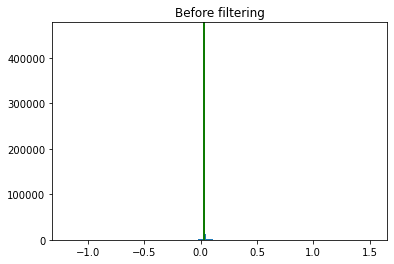

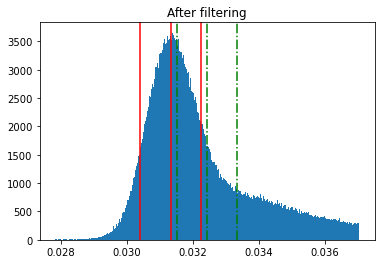

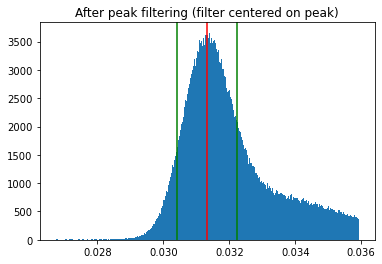

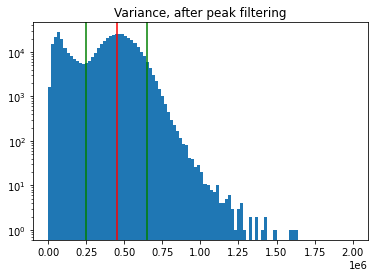

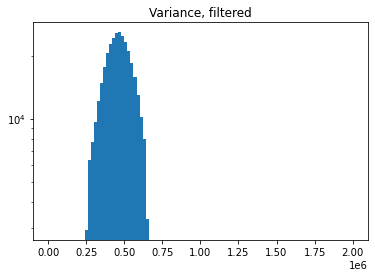

In [16]:
Sazi_fvar, Sazi_var_fvar, cellID_fvar, pump_fvar, pulseIDs_fvar, trainIDs_fvar = filter_var(Sazi_df, Sazi_var_df, q, [0.1, 2.5], cellID_df, pump_df, pulseIDs_df, trainIDs_df, sigma=5, mean_bounds=[0.01,0.04], sigma_peak = 5, peakvar = 0.45e6, varbounds = 0.2e6)

# CALCULATE DIFFERENCE

In [17]:
def calc_diff(Sazi_in, q, cellID_in, pump_in):
    
   # print(Sazi_in.shape, cellID_in.shape, pump_in.shape)
    
    
    cells = np.unique(cellID_in)
    #print(cells.shape)
    S_on = np.zeros([len(cells), len(q)])
    S_off = np.zeros([len(cells), len(q)])
    for i in range(cells.shape[0]):
        S_on[i,:] = np.nanmean(Sazi_in[np.logical_and(pump_in==1, cellID_in==cells[i]),:],0)    
        S_off[i,:] = np.nanmean(Sazi_in[np.logical_and(pump_in==0, cellID_in==cells[i]),:],0)
    dS = S_on - S_off
    return dS, S_on, S_off


In [18]:
dS_mf, S_mf_on, S_mf_off = calc_diff(Sazi_mf, q, cellID_mf, pump_mf)

In [29]:
dS_pf, S_pf_on, S_pf_off = calc_diff(Sazi_pf, q, cellID_pf, pump_pf)

In [20]:
dS_fvar, S_fvar_on, S_fvar_off = calc_diff(Sazi_fvar, q, cellID_fvar, pump_fvar)

# COUNT FRAMES FOR EACH TIMEPOINT

In [21]:
def count_frames_per_tp(cellID_in, pump_in):
    

    # initialize arrays of pulse ids that will hold how many frames we have of that pulse
    counts = np.ones(max(cellID_in))*np.nan
    counts_on = np.ones(max(cellID_in))*np.nan
    counts_off = np.ones(max(cellID_in))*np.nan
    
    # for each pulse id, 
    for cell_id_check in range(max(cellID_in)):

        #count (sum) how many frames have that id
        counts[cell_id_check] = np.nansum( (cellID_in==cell_id_check) )

      
    
    pump_on = pump_in[:]
    
    cellID_pump_on_masked = cellID_in*pump_in
    max_cellID = np.max(cellID_pump_on_masked)
    
    for cell_id_check in range(max(cellID_in)):
        
        counts_on[cell_id_check] = np.nansum( (cellID_pump_on_masked==cell_id_check) )

        
        
    pump_off = pump_in[:]
    pump_off = np.where(pump_in == 1, 0, 1)
    #loc1 = np.where(pump_in==1)     
    #loc0 = np.where(pump_in==0)
    #pump_off[loc1]=0
    #pump_off[loc0]=1
    
   
    cellID_pump_off_masked = cellID_in*pump_off
    #print(cellID_pump_off_masked.max())
    max_cellID = np.max(cellID_pump_off_masked)
       
    
    for cell_id_check in range(max(cellID_in)):
        
        counts_off[cell_id_check] = np.nansum( (cellID_pump_off_masked==cell_id_check) )


                                                                              
    return counts, counts_on, counts_off

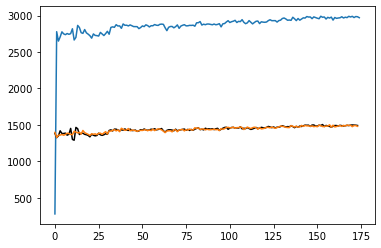

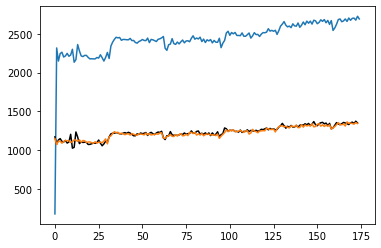

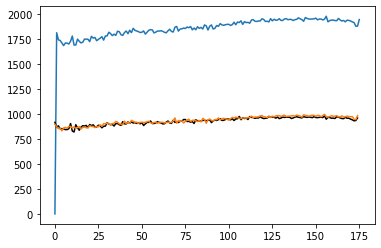

In [30]:

counts, counts_on, counts_off = count_frames_per_tp(cellID_mf, pump_mf)

plt.figure()
plt.plot(counts[0:])
plt.plot(counts_on[1:],'black')
plt.plot(counts_off[1:])

#print(counts == counts_on+counts_off)


counts, counts_on, counts_off = count_frames_per_tp(cellID_pf, pump_pf)

plt.figure()
plt.plot(counts[0:])
plt.plot(counts_on[1:],'black')
plt.plot(counts_off[1:])

#print(counts == counts_on+counts_off)

counts, counts_on, counts_off = count_frames_per_tp(cellID_fvar, pump_fvar)

plt.figure()
plt.plot(counts[0:])
plt.plot(counts_on[1:],'black')
plt.plot(counts_off[1:])

#print(counts == counts_on+counts_off)


# CALCULATE DIFFERENCE BY TRAIN

In [23]:
def calc_difference_by_train():
    pass

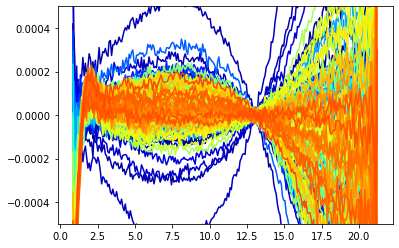

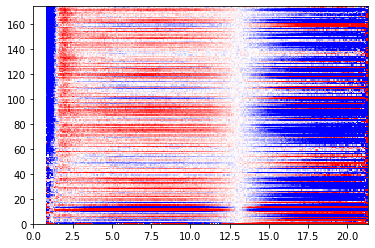

In [24]:
cells = np.unique(cellID_mf)
colors = pl.cm.jet(np.linspace(0,1,dS_mf.shape[0]))
#dS_filt =PLOT dS[mask_std,:]

fig, ax = plt.subplots(1,1)
for i in range(dS_mf.shape[0]-30):
    ax.plot(q, dS_mf[i+3,:].T, color = colors[i])
    ax.set_ylim([-.0005,.0005])
    

cmin = -0.0002
cmax = 0.0002
    
fig, ax = plt.subplots(1,1)
ax.pcolor(q, cells[:175], dS_mf[:175], cmap='bwr',vmin=cmin, vmax=cmax)



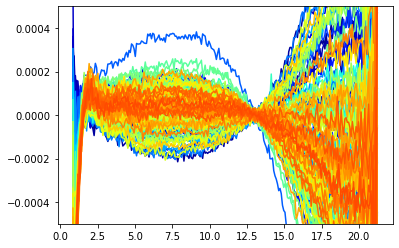

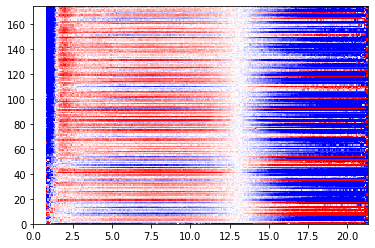

In [31]:
cells = np.unique(cellID_pf)
colors = pl.cm.jet(np.linspace(0,1,dS_pf.shape[0]))
#dS_filt =PLOT dS[mask_std,:]

fig, ax = plt.subplots(1,1)
for i in range(dS_pf.shape[0]-30):
    ax.plot(q, dS_pf[i+3,:].T, color = colors[i])
    ax.set_ylim([-.0005,.0005])
    

cmin = -0.0002
cmax = 0.0002
    
fig, ax = plt.subplots(1,1)
ax.pcolor(q, cells[:175], dS_pf[:175], cmap='bwr',vmin=cmin, vmax=cmax)



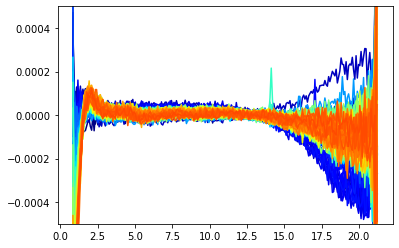

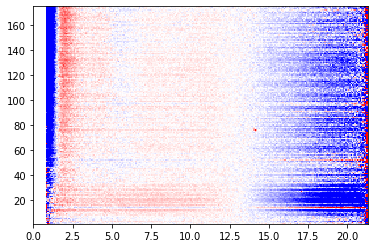

In [26]:
cells = np.unique(cellID_fvar)
colors = pl.cm.jet(np.linspace(0,1,dS_fvar.shape[0]))
#dS_filt =PLOT dS[mask_std,:]

fig, ax = plt.subplots(1,1)
for i in range(dS_fvar.shape[0]-30):
    ax.plot(q, dS_fvar[i+3,:].T, color = colors[i])
    ax.set_ylim([-.0005,.0005])
    

cmin = -0.0002
cmax = 0.0002
    
fig, ax = plt.subplots(1,1)
ax.pcolor(q, cells[:175], dS_fvar[:175], cmap='bwr',vmin=cmin, vmax=cmax)



In [27]:
#np.save(f'/gpfs/exfel/exp/SPB/202202/p003046/scratch/data/pa_filtered_runs/dS_run{run}.npy', dS)
#np.save(f'/gpfs/exfel/exp/SPB/202202/p003046/scratch/data/pa_filtered_runs/qs_run{run}.npy', q)
#np.save(f'/gpfs/exfel/exp/SPB/202202/p003046/scratch/data/pa_filtered_runs/counts_on_run{run}.npy', counts_on)
#np.save(f'/gpfs/exfel/exp/SPB/202202/p003046/scratch/data/pa_filtered_runs/counts_off_run{run}.npy', counts_off)
